In [99]:
from __future__ import print_function
import time
import boto3
import json
from sagemaker import get_execution_role

REGION = 'us-west-2'
BUCKET = 'jashuang-sagemaker-5-22'
OUTPUT_PATH = f's3://{BUCKET}/a2i-results'

ROLE = get_execution_role()
display(ROLE)
# need to attach policies

'arn:aws:iam::688520471316:role/service-role/AmazonSageMaker-ExecutionRole-20200522T134110'

In [43]:
## ComprehendFullAccess 
## AmazonSageMakerFullAccess 
## AmazonS3FullAccess 
## AmazonAugmentedAIFullAccess

In [117]:
transcribe = boto3.client('transcribe', REGION)
s3 = boto3.client("s3", REGION)
job_name_1 = "AWS-sage-1"
# audio file path
job_uri_1 = "https://jashuang-sagemaker-5-22.s3-us-west-2.amazonaws.com/transcribe-bucket/Fully-Managed+Notebook+Instances+with+Amazon+SageMaker+-+a+Deep+Dive.mp4"
job_uri_s3 = "s3://jashuang-sagemaker-5-22/transcribe-bucket/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4"
out_bucket = "jashuang-sagemaker-5-22"

In [5]:
# transcribe.start_transcription_job(
#     TranscriptionJobName=job_name,
#     Media={'MediaFileUri': job_uri},
#     MediaFormat='mp4',
#     LanguageCode='en-US'
# )

In [6]:
def transcribe(job_name, job_uri, out_bucket, format="mp4"):
    """Transcribe a .wav or .mp4 file to text.
    Args:
        job_name (str): the name of the job that you specify;
                        the output json will be job_name.json
        job_uri (str): input path (in s3) to the file being transcribed
        out_bucket (str): s3 bucket name that you want the output json
                          to be placed in
        format (str): mp4 or wav for input file format;
                      defaults to mp4
    """
    
    if format not in ['mp3','mp4','wav','flac']:
        print("Invalid format")
        return

    try:
        transcribe = boto3.client("transcribe")
        print("------" + format)
        transcribe.start_transcription_job(
            TranscriptionJobName=job_name,
            Media={"MediaFileUri": job_uri},
            MediaFormat=format,
            LanguageCode="en-US",
            OutputBucketName=out_bucket,
        )
        
        while True:
            status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Not ready yet...")
            time.sleep(5)
        print(status)

    except Exception as e:
        print(e)

In [75]:
def get_transcript_text_and_timestamps(bucket_name, file_name):
    """take json file from s3 bucket and returns a tuple of:
       entire transcript, list object of tuples of timestamp and individual sentences
    
    Args:
        bucket_name (str): name of s3 bucket
        file_name (str): name of file
    Returns:
        (entire_transcript: str,
        [ {timestamp (in seconds) : int, sentence : str} ])
    """
    s3_clientobj = s3.get_object(Bucket=bucket_name, Key=file_name)
    s3_clientdata = s3_clientobj["Body"].read().decode("utf-8")

    original = json.loads(s3_clientdata)
    items = original["results"]["items"]
    entire_transcript = original["results"]["transcripts"]

    sentences_and_times = []
    temp_sentence = ""
    temp_start_time = 0
    temp_min_confidence = 1.0
    newSentence = True
    
    confidences = []
    scores = []

    i = 0
    for item in items:
        # always add the word
        if item["type"] == "punctuation":
            temp_sentence = (
                temp_sentence.strip() + item["alternatives"][0]["content"] + " "
            )
        else:
            temp_sentence = temp_sentence + item["alternatives"][0]["content"] + " "
            temp_min_confidence = min(temp_min_confidence,
                                      float(item["alternatives"][0]["confidence"]))
            confidences.append({"start_time": float(item["start_time"]),
                                "end_time": float(item["end_time"]),
                                "content": item["alternatives"][0]["content"],
                                "confidence": float(item["alternatives"][0]["confidence"])
                               })
            scores.append(float(item["alternatives"][0]["confidence"]))

        # if this is a new sentence, and it starts with a word, save the time
        if newSentence == True:
            if item["type"] == "pronunciation":
                temp_start_time = float(item["start_time"])
            newSentence = False
        # else, keep going until you hit a punctuation
        else:
            if (
                item["type"] == "punctuation"
                and item["alternatives"][0]["content"] != ","
            ):
                # end time of sentence is end_time of previous word
                end_time = items[i-1]["end_time"] if i-1 >= 0 else items[0]["end_time"]
                sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": end_time,
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
                # reset the temp sentence and relevant variables
                newSentence = True
                temp_sentence = ""
                temp_min_confidence = 1.0
                
        i = i + 1

    return entire_transcript, sentences_and_times, confidences, scores

In [54]:
# transcribe(job_name_1, job_uri_1, out_bucket)

In [76]:
entire_transcript_1, sentences_and_times_1, confidences_1, scores = get_transcript_text_and_timestamps("jashuang-sagemaker-5-22","AWS-sage-1.json")

In [12]:
# entire_transcript_1

In [19]:
# print(scores)

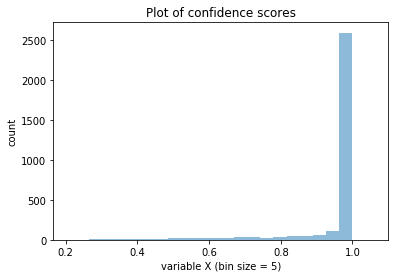

In [94]:
from matplotlib import pyplot as plt

plt.xlim([min(scores)-0.1, max(scores)+0.1])
plt.hist(scores, bins=20, alpha=0.5)
plt.title('Plot of confidence scores')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()

In [41]:
import numpy as np
print(len(scores))

3174


In [35]:
bad_scores = [i for i in scores if i < 0.9]

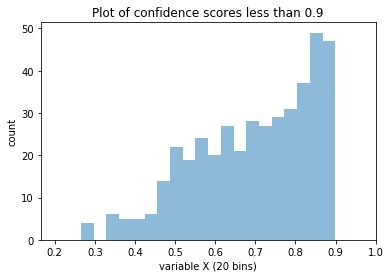

In [39]:
plt.xlim([min(bad_scores)-0.1, 1.0])
plt.hist(bad_scores, bins=20, alpha=0.5)
plt.title('Plot of confidence scores less than 0.9')
plt.xlabel('variable X (20 bins)')
plt.ylabel('count')

plt.show()

In [40]:
len(bad_scores)

421

In [106]:
# for tup in sentences_and_times_1:
#     print(str(tup['start_time']) + " -- "  +
#           str(tup['end_time']) + " -- "+
#           tup['sentence']+ " -- "+
#           str(tup['min_confidence'])
#          )

In [96]:
WORKTEAM_ARN= "arn:aws:sagemaker:us-west-2:688520471316:workteam/private-crowd/jashuang-test-workforce"

In [97]:
import io
import json
import uuid
import time
import boto3
import botocore

# Amazon SageMaker client
sagemaker = boto3.client('sagemaker', REGION)

# Amazon Comprehend client
comprehend = boto3.client('comprehend', REGION)

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

s3 = boto3.client('s3', REGION)

In [153]:
template = r"""
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
    <video controls>
        <source src="{{ task.input.audioPath | grant_read_access }}#t={{ task.input.start_time }},{{ task.input.end_time }}"
            type="audio/mp4">
        Your browser does not support the audio element.
    </video>
    <p>If you need to replay the audio, please refresh the page.</p>

    <h3>Instructions</h3>
    <p>Transcribe the audio </p>
    <p>Ignore "umms", "hmms", "uhs" and other non-textual phrases. </p>
    <p>The original transcript is <strong>"{{ task.input.original_words }}"</strong>. If the text matches the audio, please retype the same transcription.</p>
    <p>Click the space below to start typing.</p>
    <crowd-text-area name="transcription" rows="2"></crowd-text-area>

    <full-instructions header="Transcription Instructions">
        <h2>Instructions</h2>
        <p>Click the play button once and listen carefully to the audio section clip. Type what you hear in the box
            below.</p>
    </full-instructions>

</crowd-form>
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [154]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-transcribe-' + str(uuid.uuid4()) 

# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-west-2:688520471316:human-task-ui/ui-transcribe-34c3252c-b50e-41c0-8d6f-47dba65f5db0


In [155]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'fd-transcribe-demo-' + str(uuid.uuid4()) 

create_workflow_definition_response = sagemaker.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= ROLE,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify the word(s) spoken in the provided audio clip",
            "TaskTitle": "Determine Words/Phrases of Audio Clip"
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [156]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Active
Flow Definition is active


In [82]:
print(confidences_1[0:1])

[{'start_time': 0.54, 'end_time': 1.03, 'content': 'Hi', 'confidence': 1.0}]


In [157]:
# use this to get the words near a word with poor confidence,
# since it is possible that the transcription also mis-transcribed nearby words/phrases
def get_word_neighbors(words, index):
    """
    gets the words transcribe found at most 3 away from the input index
    Returns:
    list: words at most 3 away from the input index
    int: starting time of the first word in the list
    int: ending time of the last word in the list
    """
    i = max(0, index - 3)
    j = min(len(words) - 1, index + 3)
    return words[i: j + 1], words[i]["start_time"], words[j]["end_time"]

In [137]:
words_list, start, end = get_word_neighbors(confidences_1, 5)
print(words_list)
print(len(words_list))
print(start)
print(end) #hello

[{'start_time': 1.5, 'end_time': 1.7, 'content': 'name', 'confidence': 1.0}, {'start_time': 1.7, 'end_time': 1.85, 'content': 'is', 'confidence': 1.0}, {'start_time': 1.85, 'end_time': 2.1, 'content': 'Emily', 'confidence': 0.9886}, {'start_time': 2.1, 'end_time': 2.51, 'content': 'Weber', 'confidence': 0.7289}, {'start_time': 2.74, 'end_time': 2.97, 'content': "I'm", 'confidence': 0.9645}, {'start_time': 2.97, 'end_time': 3.11, 'content': 'a', 'confidence': 1.0}, {'start_time': 3.11, 'end_time': 3.43, 'content': 'machine', 'confidence': 1.0}]
7
1.5
3.43


In [138]:
sequence = ""
for block in words_list:
    sequence += block['content'] + " "
print(sequence)

name is Emily Weber I'm a machine 


In [62]:
# bad_conf_words = []
# i=0
# for obj in confidences_1:
#     if obj['confidence'] < 0.4:
#         bad_conf_words.append(obj)
#     i=i+1

In [68]:
# print(bad_conf_words[2])

{'start_time': 91.02, 'end_time': 91.36, 'content': 'Annecy', 'confidence': 0.3542}


In [158]:
# Sample data, human loop started
human_loops_started = []
CONFIDENCE_SCORE_THRESHOLD = .4
i = 0
for obj in confidences_1:
    word = obj["content"]
    neighbors, start_time, end_time = get_word_neighbors(confidences_1, i)
    
#     print(f'Processing word: \"{obj["content"]}\"')
    
    # Our condition for when we want to engage a human for review
    if (obj["confidence"] < CONFIDENCE_SCORE_THRESHOLD):
        
        # get the original sequence of words
        sequence = ""
        for block in neighbors:
            sequence += block['content'] + " "
        
        humanLoopName = str(uuid.uuid4())
        # "initialValue": word,
        inputContent = {
            "audioPath": job_uri_s3,
            "start_time": start_time,
            "end_time": end_time,
            "original_words": sequence
        }
        start_loop_response = a2i.start_human_loop(
            HumanLoopName=humanLoopName,
            FlowDefinitionArn=flowDefinitionArn,
            HumanLoopInput={
                "InputContent": json.dumps(inputContent)
            }
        )
        human_loops_started.append(humanLoopName)
        print(f'Confidence score of {obj["confidence"]} is less than the threshold of {CONFIDENCE_SCORE_THRESHOLD}')
        print(f'Starting human loop with name: {humanLoopName}')
        print(f'Sending words from times {start_time} to {end_time} to review')
        print(f'The original transcription is ""{sequence}"" \n')
#     else:
# #         print(f'SentimentScore of {obj["confidence"]} is above threshold of {CONFIDENCE_SCORE_THRESHOLD}')
# #         print('No human loop created. \n')

    i=i+1

Confidence score of 0.3945 is less than the threshold of 0.4
Starting human loop with name: 6228b6ee-0a2e-4376-954a-065044664e71
Sending words from times 44.2 to 46.37 to review
The original transcription is ""show up Under are easy to console "" 

Confidence score of 0.3907 is less than the threshold of 0.4
Starting human loop with name: f4117366-8aeb-4c33-b7c6-2d1620a471c5
Sending words from times 69.11 to 72.08 to review
The original transcription is ""And more cores see is compute optimized "" 

Confidence score of 0.3542 is less than the threshold of 0.4
Starting human loop with name: 92116669-2e55-44a3-b738-303a566494cc
Sending words from times 89.94 to 92.93 to review
The original transcription is ""every version of Annecy two instance is "" 

Confidence score of 0.3372 is less than the threshold of 0.4
Starting human loop with name: 87dd39a8-3b4b-4137-8962-db517846223b
Sending words from times 338.43 to 340.78 to review
The original transcription is ""distributing data sets wan

In [145]:
# Check Status of Human Loop

completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)



HumanLoop Name: d9f7924c-a537-4d68-b20b-efa1aea6047d
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-81e31b2e-868a-4ee7-bcda-0a5061288caa/2020/05/28/22/47/18/d9f7924c-a537-4d68-b20b-efa1aea6047d/output.json'}


HumanLoop Name: dd512792-2a2a-4e99-af27-75a6722c3a82
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-81e31b2e-868a-4ee7-bcda-0a5061288caa/2020/05/28/22/47/18/dd512792-2a2a-4e99-af27-75a6722c3a82/output.json'}


HumanLoop Name: f1e34d39-4538-44d8-9a14-2b9efa65909f
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-81e31b2e-868a-4ee7-bcda-0a5061288caa/2020/05/28/22/47/18/f1e34d39-4538-44d8-9a14-2b9efa65909f/output.json'}


HumanLoop Name: d9bad680-eb6c-4b2c-8dc1-fdd950761dbe
HumanLoop Status: InProgress
HumanLoop Output Dest

In [109]:
# Wait For Workers to Complete Task
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://v3t960yxw8.labeling.us-west-2.sagemaker.aws


In [161]:
# Check Status of Human Loop Again

completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)



HumanLoop Name: 6228b6ee-0a2e-4376-954a-065044664e71
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-dda504eb-2b7e-4367-b05b-239d9be0cb95/2020/05/28/23/50/16/6228b6ee-0a2e-4376-954a-065044664e71/output.json'}


HumanLoop Name: f4117366-8aeb-4c33-b7c6-2d1620a471c5
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-dda504eb-2b7e-4367-b05b-239d9be0cb95/2020/05/28/23/50/16/f4117366-8aeb-4c33-b7c6-2d1620a471c5/output.json'}


HumanLoop Name: 92116669-2e55-44a3-b738-303a566494cc
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-dda504eb-2b7e-4367-b05b-239d9be0cb95/2020/05/28/23/50/16/92116669-2e55-44a3-b738-303a566494cc/output.json'}


HumanLoop Name: 87dd39a8-3b4b-4137-8962-db517846223b
HumanLoop Status: Completed
HumanLoop Output Destinat

In [162]:

# View Task Results¶

# Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 OUTPUT_PATH when all work is completed.

import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')



{   'flowDefinitionArn': 'arn:aws:sagemaker:us-west-2:688520471316:flow-definition/fd-transcribe-demo-dda504eb-2b7e-4367-b05b-239d9be0cb95',
    'humanAnswers': [   {   'answerContent': {   'transcription': 'show up '
                                                                  'under our '
                                                                  'ec2 '
                                                                  'console'},
                            'submissionTime': '2020-05-29T00:10:03.874Z',
                            'workerId': '65bf0cafa9867643'}],
    'humanLoopName': '6228b6ee-0a2e-4376-954a-065044664e71',
    'inputContent': {   'audioPath': 's3://jashuang-sagemaker-5-22/transcribe-bucket/Fully-Managed '
                                     'Notebook Instances with Amazon SageMaker '
                                     '- a Deep Dive.mp4',
                        'end_time': 46.37,
                        'original_words': 'show up Under are easy to con

In [163]:
corrected_words = []

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    
    # add the human-reviewed answers split by spaces
    corrected_words += json_output['humanAnswers'][0]['answerContent']['transcription'].split(" ")

In [164]:
print(corrected_words)

['show', 'up', 'under', 'our', 'ec2', 'console', 'and', 'more', 'cores', 'c', 'is', 'compute', 'optimized', 'every', 'version', 'of', 'an', 'ec2', 'instance', 'is', 'idk', 'onto', 'your', 'EBS', 'volume', 'and', 'again', "that's", 'of', 'those', 'example', 'notebooks', 'are', 'open', 'the', 'two', 'main', 'ones', 'markdown', 'is', 'gonna', 'I', 'started', 'using', 'boto3', 'but', 'I', 'absolutely', 'upgrade', 'and', 'its', 'fun', 'because', 'you', "that's", 'that', 'python', 'SDK', "we're", 'getting', 'the', 'python', 'SDK', "we're", 'getting', 'our', 'the', 'internet', 'so', 'this', 'is', 'from', 'this', 'is', 'from', 'Sarab', "he's", 'the', 'author', 'right', 'up', 'here', 'then', 'the', 'title', 'of', 'but', 'definitely', 'use', 'Lambda', 'to', 'turn', 'your', 'then', 'edit', 'your', 'ec2', 'instance', 'or', 'the']
